# ** Recommender systems**

The dataset provided represents product views across our websites over two days.

`fullVisitorId` is a distinct user, or cookie.

`productId` represents a product a specific user has viewed.

In this task we would compute a co-occurrence matrix, build a recommender system leveraging that matrix in some manner, and a method to recommend new products to a set of users provided below.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## STEP 0:
*Import the data*

*First, please add the dataset named dataset.csv from the link provided to your own drive.*

In [ ]:
import pandas as pd
import csv
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [ ]:
with open('/gdrive/My Drive/dataset.csv') as f:
  data = pd.read_csv(f)

In [ ]:
data.head(2)

,fullVisitorId,productId
0,10000210821186390039,19477
1,10000210821186390039,13755


In [ ]:
len(data)

510413

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510413 entries, 0 to 510412
Data columns (total 2 columns):
fullVisitorId    510413 non-null uint64
productId        510413 non-null int64
dtypes: int64(1), uint64(1)
memory usage: 7.8 MB


## Simple EDA


In [ ]:
import seaborn as sns

In [ ]:
print('Unique Visitors: {} and Unique Products: {} '.format(data.fullVisitorId.nunique(),
                                                         data.productId.nunique()))

Unique Visitors: 87411 and Unique Products: 12888 


In [ ]:
# Check for 1 to 1 mapping with visitor_id to product_id
mapping = data.groupby(['fullVisitorId','productId']).size().reset_index().rename(columns = {0:'count'})
print ('Mappings with more than 1 product visited by user : {}'.format(mapping[mapping['count'] > 1].shape[0]))

Mappings with more than 1 product visited by user : 0


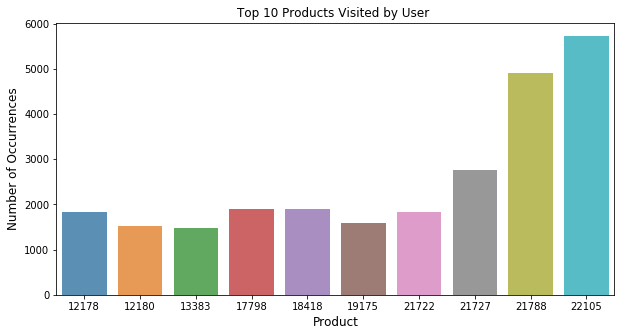

In [ ]:
# Top 10 Products 
product_count  = data['productId'].value_counts()
product_count = product_count[:10,]
plt.figure(figsize=(10,5))
sns.barplot(product_count.index, product_count.values, alpha=0.8)
plt.title('Top 10 Products Visited by User ')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.show()

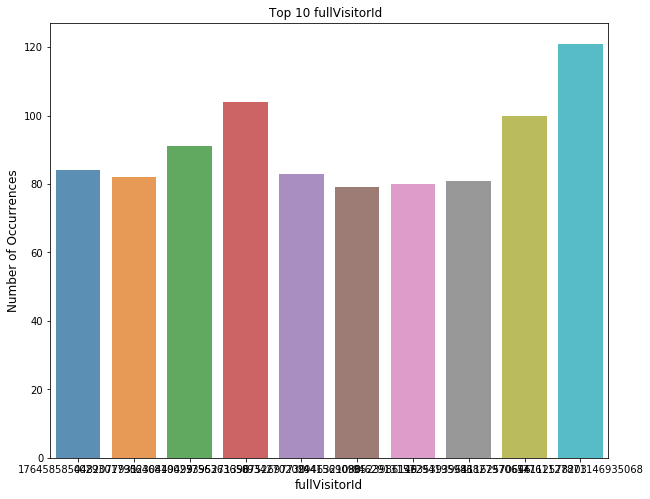

In [ ]:
# Top 10 users 
fullVisitorId_count  = data['fullVisitorId'].value_counts()
fullVisitorId_count = fullVisitorId_count[:10,]
plt.figure(figsize=(10,8))
sns.barplot(fullVisitorId_count.index, fullVisitorId_count.values, alpha=0.8)
plt.title('Top 10 fullVisitorId  ')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('fullVisitorId', fontsize=12)
plt.show()

## STEP 1:
*Compute the **co-occurrence** matrix.*

In [ ]:
#Get the views of the user-product pair
data['views'] = data.groupby(['fullVisitorId','productId'])['productId'].transform('count')

Co-occurence matrix have specific entities in rows and entities in columns .
Number of times each entities in rows appears in same context as each entities in columns.

In [ ]:
#Co-occurrence matrix for users and products which are viewed as 1 else 0
users_items_pivot_matrix_df = data.pivot(
    columns='productId',
    index='fullVisitorId',
    values='views'
).fillna(0)

print (users_items_pivot_matrix_df.shape)

(87411, 12888)


In [ ]:
users_items_pivot_matrix_df[:3]


productId,2,7,10,11,13,14,15,16,18,19,20,21,22,24,27,28,33,37,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,...,22031,22032,22033,22035,22036,22037,22038,22039,22040,22041,22042,22072,22104,22105,22107,22108,22109,22110,22111,22112,22113,22114,22115,22116,22117,22119,22120,22121,22122,22123,22124,22125,22127,22128,22129,22237,22241,22251,22269,22793
fullVisitorId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
14776257780237,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31065480157626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95238177475911,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## STEP 2 :
**Recommendation system**  using Matrix Factorization 

Matrix Factorization: 
Latent factor models compress user-item matrix into a low-dimensional representation in terms of latent factors. One advantage of using this approach is that instead of having a high dimensional matrix containing abundant number of missing values we will be dealing with a much smaller matrix in lower-dimensional space.
A reduced presentation could be utilized for either user-based or item-based neighborhood algorithms that are presented in the previous section. There are several advantages with this paradigm. It handles the sparsity of the original matrix better than memory based ones. Also comparing similarity on the resulting matrix is much more scalable especially in dealing with large sparse datasets.

Here we will use popular latent factor model named Singular Value Decomposition (SVD). We will use a SciPy implemenation of SVD.

An important decision is the number of factors to factor the user-item matrix. The higher the number of factors, the more precise is the factorization in the original matrix reconstructions. Therefore, if the model is allowed to memorize too much details of the original matrix, it may not generalize well for data it was not trained on. Reducing the number of factors increases the model generalization.

In [ ]:
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

In [ ]:
# Get the vaues from pivot user items dataframes
users_items_pivot_matrix = users_items_pivot_matrix_df.as_matrix()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [ ]:
# Get the user_id index
users_ids = list(users_items_pivot_matrix_df.index)
users_ids[:10]

[14776257780237,
 31065480157626,
 95238177475911,
 177665260713177,
 311397934795069,
 362488222534304,
 425104548140923,
 538465917568470,
 797491100134050,
 932061015551067]

In [ ]:
#Convert the matrix to sparse matrix
users_items_pivot_sparse_matrix = csr_matrix(users_items_pivot_matrix)
users_items_pivot_sparse_matrix

<87411x12888 sparse matrix of type '<class 'numpy.float64'>'
	with 510413 stored elements in Compressed Sparse Row format>

In [ ]:
#The number of factors to factor the user-item matrix.
NUMBER_OF_FACTORS_MF = 15

#Performs matrix factorization of the original user item matrix
U, sigma, Vt = svds(users_items_pivot_sparse_matrix, k = NUMBER_OF_FACTORS_MF)

In [ ]:
#Unitary matrix having left singular vectors as columns
U.shape

(87411, 15)

In [ ]:
#Unitary matrix having right singular vectors as rows. 
Vt.shape

(15, 12888)

In [ ]:
#The singular values, sorted in non-increasing order
sigma = np.diag(sigma)
sigma.shape

(15, 15)

After the factorization, we will try to to reconstruct the original matrix by multiplying its factors. The resulting matrix is not sparse any more. It was generated predictions for products the user have not yet interaction, which we will exploit for recommendations.

In [ ]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)

In [ ]:
# Get the predictions for all user products 
cf_preds_df = pd.DataFrame(all_user_predicted_ratings, 
                           columns = users_items_pivot_matrix_df.columns, index=users_ids)

In [ ]:
cf_preds_df.head()

productId,2,7,10,11,13,14,15,16,18,19,20,21,22,24,27,28,33,37,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,...,22031,22032,22033,22035,22036,22037,22038,22039,22040,22041,22042,22072,22104,22105,22107,22108,22109,22110,22111,22112,22113,22114,22115,22116,22117,22119,22120,22121,22122,22123,22124,22125,22127,22128,22129,22237,22241,22251,22269,22793
14776257780237,-2.408083e-05,8.422041e-06,2.194851e-06,1.130629e-06,-1.680490e-09,1.235560e-06,4.181933e-08,7.080583e-08,1.394550e-06,2.703122e-08,1.360884e-07,2.827942e-07,2.703122e-08,6.899581e-08,3.134178e-07,-1.680490e-09,-9.949266e-06,2.703122e-08,1.782828e-07,4.179563e-07,2.703122e-08,2.135894e-08,2.757901e-07,9.928050e-07,5.413330e-06,3.022626e-06,1.710824e-07,4.032417e-06,5.035608e-06,4.280826e-06,7.917171e-06,1.387969e-05,2.656295e-06,2.856271e-06,9.010406e-06,3.947740e-06,1.724721e-05,4.488953e-06,5.062242e-06,4.638111e-07,...,-0.000409,-1.626642e-04,-0.000449,-6.464089e-04,0.001040,-0.000770,-0.005012,-0.000444,-0.000405,-0.000145,-0.000329,0.000884,-0.009658,-0.002391,-0.000581,-0.000391,-0.000107,0.000077,0.000008,0.000937,0.002387,7.941014e-06,0.001027,0.000482,0.002771,0.009562,0.010790,0.004977,0.007773,0.020178,0.009933,0.010051,0.006818,0.001235,0.002790,4.463396e-05,4.604150e-05,-6.744842e-06,4.013011e-07,-1.005210e-06
31065480157626,3.162999e-06,1.572601e-07,2.606396e-08,1.977985e-08,3.139384e-10,2.838000e-08,3.979778e-10,5.624702e-10,1.438722e-08,2.959497e-10,6.141880e-07,2.693408e-09,2.959497e-10,1.063275e-09,2.367398e-09,3.139384e-10,1.900593e-06,2.959497e-10,2.313748e-09,1.154556e-08,2.959497e-10,3.011178e-10,9.071041e-09,1.852268e-08,1.291028e-07,4.584048e-08,1.966816e-09,6.298723e-08,8.310406e-08,8.986052e-08,1.411689e-07,1.260222e-07,5.662970e-08,4.729727e-08,1.851424e-07,6.490435e-08,2.805600e-07,7.739261e-08,7.341234e-08,9.969074e-09,...,-0.000011,-6.197062e-06,-0.000016,-2.188134e-05,0.000039,-0.000044,-0.000206,-0.000081,-0.000267,-0.000014,-0.000020,0.000036,-0.000865,-0.000516,-0.000014,-0.000023,-0.000008,0.000008,0.000001,0.000060,0.000072,2.754667e-07,0.000101,0.000018,0.000103,0.000362,0.000286,0.000208,0.000315,0.000751,0.000327,0.000474,0.000268,0.000035,0.000085,1.940198e-06,1.979378e-06,1.021011e-08,1.271476e-08,3.600467e-07
95238177475911,-7.046647e-07,8.738770e-07,1.821948e-07,7.485345e-08,-4.789940e-11,1.096259e-07,4.215472e-09,6.488635e-09,1.505368e-07,3.196488e-09,-1.737359e-08,3.366125e-08,3.196488e-09,1.486758e-08,3.697627e-08,-4.789940e-11,7.525746e-08,3.196488e-09,2.159913e-08,4.252741e-08,3.196488e-09,1.064082e-09,5.962337e-08,6.122060e-08,4.241552e-07,1.849884e-07,1.321690e-08,2.472831e-07,2.954206e-07,3.321289e-07,7.324984e-07,1.626789e-06,1.941049e-07,2.504740e-07,8.069689e-07,2.310108e-07,1.226848e-06,1.832427e-07,3.765865e-07,7.127826e-08,...,0.000008,1.270642e-08,0.000019,8.500291e-06,0.000032,0.000027,0.000098,0.000062,0.000134,0.000015,0.000015,0.000043,0.000276,0.000701,0.000015,0.000016,0.000003,0.000011,0.000005,0.000077,0.000104,4.790215e-07,0.000118,0.000023,0.000077,0.000304,0.000241,0.000185,0.000224,0.000582,0.000268,0.000344,0.000252,0.000053,0.000102,1.204669e-06,1.293809e-06,4.978280e-07,6.397096e-08,-1.547741e-07
177665260713177,-2.691678e-04,1.606043e-05,2.166766e-06,1.595376e-06,-1.230829e-08,1.111319e-07,6.503740e-08,9.466157e-08,2.011810e-06,4.768705e-08,3.240908e-07,5.508626e-07,4.768705e-08,6.029761e-07,6.234702e-07,-1.230829e-08,-1.319368e-04,4.768705e-08,3.814419e-07,8.259295e-07,4.768705e-08,2.291546e-08,2.739029e-06,3.328719e-07,5.343272e-06,2.373435e-07,1.147368e-07,5.390437e-07,3.249141e-06,3.872202e-06,1.187780e-05,2.748596e-05,6.213740e-07,2.382602e-06,1.286810e-05,2.218300e-06,1.362357e-05,2.513921e-06,3.262356e-06,1.224614e-06,...,0.002759,9.840895e-04,0.000038,8.185914e-03,0.013917,0.004495,0.044335,0.024300,0.052860,0.001108,0.001994,0.004471,0.095707,1.015160,0.002174,0.005853,0.001815,0.001411,0.000293,0.007232,0.007603,1.153348e-05,0.014791,0.001325,0.008073,0.028777,0.02

## STEP 3 : 

*Based on your chosen strategy, recommend **3 new products** for each of the following fullVisitorIds:*
- 10000210821186390039 
- 10000600839717498451
- 10001812885471967449
 

In [ ]:
# Get the predicitions for user_id mentioned above
test_df = cf_preds_df[cf_preds_df.index.isin([10000210821186390039,10000600839717498451,10001812885471967449])]
test_df = test_df.unstack().reset_index().rename(columns = {'level_1':'fullVisitorId',0:'rank_prob'})

In [ ]:
#Get the top 3 new products recommendations
test_df_top3 = test_df.groupby(['fullVisitorId']).apply(lambda x: x.sort_values(["rank_prob"],
                                                          ascending = False)).reset_index(drop=True)
test_df_top3.groupby(['fullVisitorId']).head(3)                                                    

,productId,fullVisitorId,rank_prob
0,10759,10000210821186390039,0.018183
1,20038,10000210821186390039,0.014327
2,94,10000210821186390039,0.012456
12888,15103,10000600839717498451,0.086144
12889,15102,10000600839717498451,0.074398
12890,15150,10000600839717498451,0.055184
25776,14096,10001812885471967449,0.020240
25777,20038,10001812885471967449,0.018604
25778,10759,10001812885471967449,0.017500
